In [51]:
import os, sys, torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import requests

btnk_dir = os.path.join(os.getcwd(), "..")
sys.path.append(btnk_dir)

## Download the example image
NOTE: the following code is taken from the original MAE repository by Meta AI (https://github.com/facebookresearch/mae/blob/main/demo/mae_visualize.ipynb)


In [52]:
def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int().cpu().numpy())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

/tmp/ipykernel_2870801/2416757493.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int().cpu().numpy())


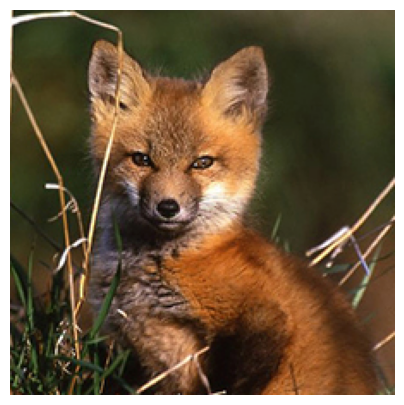

In [53]:
# load an image
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

## Load BtnkMAE Encoder and Decoder (image size: 224x224)

In [54]:
from btnk_mae import BtnkMAEEncoder, BtnkMAEDecoder
from btnk_mae.utils.patchify import unpatchify

model_size = "large_gan"
act_fn = "relu"
encoder = BtnkMAEEncoder(model_size=model_size, act_fn=act_fn)
decoder = BtnkMAEDecoder(model_size=model_size)

In [55]:
checkpoint_path = "../ckpts/large_gan/checkpoint-latest.pth"
checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
encoder.load_state_dict(checkpoint['enc_model'], strict=False)
decoder.load_state_dict(checkpoint['dec_model'], strict=False)

<All keys matched successfully>

In [56]:
img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # (1, 3, 224, 224)
latent = encoder(img_tensor)[:, 0, :]
pred_latent = decoder(latent)

/tmp/ipykernel_2870801/2181625106.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rec_img = torch.clamp(rec_img * imagenet_std + imagenet_mean, 0, 1)


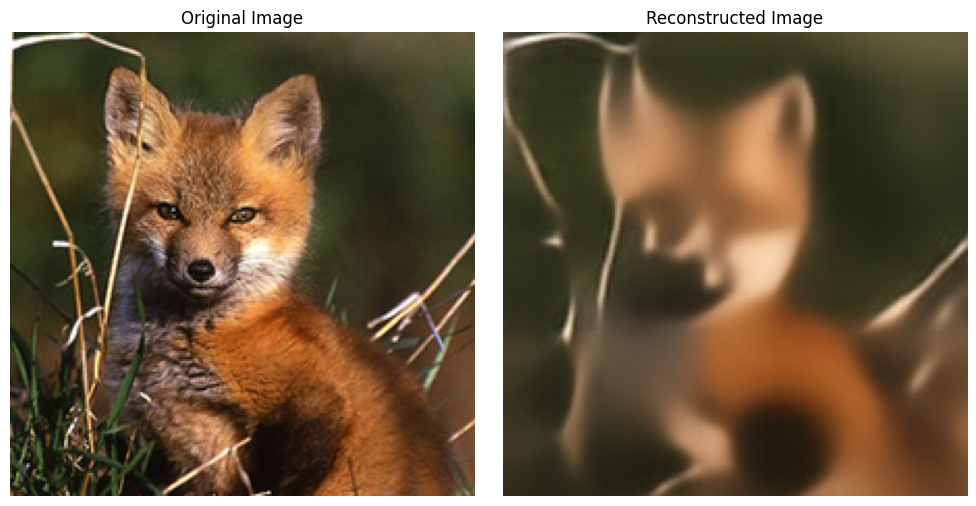

In [ ]:
rec_img = unpatchify(pred_latent, decoder.patch_size)[0].detach().cpu().permute(1, 2, 0)
rec_img = torch.clamp(rec_img * imagenet_std + imagenet_mean, 0, 1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img * imagenet_std + imagenet_mean)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2) 
plt.imshow(rec_img)
plt.title("Reconstructed Image")
plt.axis('off')
plt.tight_layout()